# Sprint 2

This notebook was created by Lennart Onghena, Roel Moeyersoons and Tim De Smet.

This project is a collaboration with ML6. They are launching a product that automates parts of big email inboxes.

During `sprint 1` we created a classifier that for the message of the customers based on the product.

During `sprint 2` we attempt to do the same using clustering by unsupervised learning instead of supervised classification.

In [3]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import re
import string
import nltk

from nltk.corpus import stopwords
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models.doc2vec import TaggedDocument
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_samples

from sklearn.cluster import DBSCAN

unable to import 'smart_open.gcs', disabling that module


# 1. EDA

All EDA steps were performed during `sprint 1`.

# 2. Preprocessing


In order to address the problems of the data, we prepared our data. For instance, we created our own product categories. We did this because we found the original Product categories to overlap. We generalized these products because we felt that, for example, all loan related complaints should be handled in a similar manner. Adding to that we balanced the dataset as well. 

When working with text however, additional steps are required.


## 2.1. Read

In [4]:
complaints = pd.read_csv('complaints-2020-01-22_08_24.csv')

## 2.2. Simplify

The following code uses a dictionary to map the original Product columns to the new ones. Using this object one could easily expand/modify the mapping when the data changes overtime.

In [5]:
# simplifying dataset
simp_map = {
    'Debt collection' : 'F', 
    'Payday loan' : 'B', 
    'Mortgage' : 'A', 
    'Bank account or service' : 'E', 
    'Consumer Loan' : 'B', 
    'Other financial service' : 'E', 
    'Vehicle loan or lease' : 'B',
    'Payday loan, title loan, or personal loan' : 'B', 
    'Money transfers' : 'E', 
    'Student loan' : 'B', 
    'Virtual currency': 'E', 
    'Credit reporting, credit repair services, or other personal consumer reports' : 'D', 
    'Credit card' : 'C', 
    'Checking or savings account' : 'E', 
    'Prepaid card' : 'C', 
    'Money transfer, virtual currency, or money service' : 'E', 
    'Credit reporting': 'D', 
    'Credit card or prepaid card' : 'C'}

featureSet = complaints[['Product', 'Consumer complaint narrative']].copy()
featureSet['TARGET'] = featureSet['Product'].map(simp_map)

## 2.3. Balancing

Learning from the EDA phase we clearly noticed that the dataset is imbalanced.
This could cause the model to collapse to the trivial solution of always returning the same prediction. We will resolve this by subsampling in order to flatten the distribution. First let's replace every category by a subsample of that category, limited to 50.000 elements.


In [6]:
for c in ['A', 'B', 'C', 'D', 'E', 'F']:
    if featureSet[featureSet['TARGET'] == c].shape[0] > 50000:
        featureSet = pd.concat(objs=[featureSet[featureSet['TARGET'] == c].sample(n=50000), featureSet[featureSet['TARGET'] != c]])

## 2.4. Sampling

Let's now take a sample from this set that shall be used during the project. The size of the subsample is very important. Too little and your model might be overtuned to some texts, while being undertuned to others. 

The bigger the subsample the more accurate your model will be for the whole dataset. However, in order to not overburden our CPU's, we limit it during the project to 10000. 

A fixed seed is also added so that the same sample is produced every time. We do this in order to keep consistency when running hte notebook several times over and over but it's not stictly needed. Needless to say this can lead to exploits where the model performs very well for this one sample. This is not our intention, the only reason the seed given below is used is because it gives an equalish amount of rows for every target. 

In [7]:
data = featureSet.sample(10000,random_state=7844569)

## 2.5. Text cleaning

We learned from `sprint 1` that cleaning the text is very important. We only applied this in the final phases of `sprint 1`. However, we decided to learn from our mistakes and do this right away during this sprint.
We can clearly see the text contains special characters, numbers, anonymized data, html, etc...
This needed to be dealt with.

In [8]:
pd.set_option('max_colwidth', None)
data[['Product','Consumer complaint narrative']].head()

,Product,Consumer complaint narrative
100190,Credit card or prepaid card,"Barclays Aadvantage Card offers a list of BENEFITS on their website including Flight Cents which rounds up miles earned. But it is NOT a BENEFIT, it's a SALES of Miles program that charges the card holder. So Surprise -- - my statement showed a Fee. I turned off this program on their website but was charged again. The customer service people refuse to turn it off, saying it must be done on the website. \n\nThey will not Turn this FEE off and will not reverse the charges and will not provide a contact phone number to speak with anyone else."
291960,Debt collection,"I received a voicemail on my office phone XX/XX/2017 The voicemail requested a call back. I called and spoke with XXXX from XXXX XXXX. He stated he was calling on behalf of XXXX in regards to a medical bill. He stated they received the file in their office on XX/XX/2017. He told me that the account had been submitted for legal, I questioned how they can do that with me not receiving any notice, he said they mailed me a letter out on the XXXX when they received the file, as of today XX/XX/2017 I still have not received written correspondence. He advised he can give me a discount if paid in full that day {$1300.00} was the original amount. He said they can break it up into XXXX payments or they can go out a year. I advised that I can do a XXXX month payment, he said that is not an option that it is against their policy only to go out a maximum of XXXX months. He again started talking about legal action and that I would have to pay the bill in full plus interest as well as court fees and attorney fees. I was extremely upset and felt as if I was being forced to do what they wanted me to do or I was going to court behind it. I told him I can look at what was doable for me and contact them back. I also requested my XXXX phone be removed from their call list. I filed a dispute on their company website right after the call disconnected. Less than XXXX hours later the I received a call from the original collector that had left msg on my XXXX phone. He said he received a message to call me back. I never once told anyone to have him call me back. I asked how the dispute worked as I had filed XXXX on their website and he stated they review it to see if the debt is valid and go from there with me proving the debt was not mine, etc. I advised him again I did not request any calls back that him calling me and making contact XXXX times in XXXX day was a FDCPA violation. He back peddled and said that the message to call me back came from his supervisor from the dispute. But not once did he try and see why I filed the dispute. He said he can offer me the XXXX month payment option?? I questioned about the policy on only going out XXXX months, I asked how XXXX rep can only give XXXX months based on policy but he can do XXXX months, he stated that it was is file and he can do that. I became very upset and cried advising him that I want to make good on it but that I felt like it was on their terms or no terms at all without it going into a legal status."
481197,"Credit reporting, credit repair services, or other personal consumer reports",for the past 90 days since XX/XX/XXXX i have not received an accurate report of my credit/XXXX XXXX i was placed as an authorize user but still never got an accurate score reflecting me as an authorize user
320576,"Money transfer, virtual currency, or money service","I did a wire transfer to Coinbase.com of XXXX to invest in cryptocurrency.\n\nI received a message on their website regarding the transfer and that it will be delayed and processed\n\nwithin 24 hours. It 's been 48+ hours now and nothing. I\n've been on hold on their phone customer support for 1 hour, TWICE in a day. I 'm not the only one experiencing issues like mine. People have even been locked out and accounts r\nemoved with way more money than me, with no reasons given."
123049,Student loan,"Two incidents of Ident

We created a function filtering out the following unwanted things:
- html
- anonymized data
- numbers
- uppercase
- stopwords

In [9]:
stopWords = stopWords = set(stopwords.words('english'))

def preprocessing(text):
    text = BeautifulSoup(text, "html.parser").text
    translator = str.maketrans('', '', string.punctuation) 
    text = text.translate(translator).lower()
    text = re.sub(r'(x)\1+', '', text)
    text = re.sub(r'[0-9]', r' ', text)
    tokens = []
    for word in text.split():
        if word not in stopWords:
            tokens.append(word)
    return " ".join(tokens)

In [10]:
data['Consumer complaint narrative'] = data['Consumer complaint narrative'].apply(preprocessing)

After applying the function to the whole column, we can see the results are as expected.

In [11]:
data[['Product','Consumer complaint narrative']].head()

,Product,Consumer complaint narrative
100190,Credit card or prepaid card,barclays aadvantage card offers list benefits website including flight cents rounds miles earned benefit sales miles program charges card holder surprise statement showed fee turned program website charged customer service people refuse turn saying must done website turn fee reverse charges provide contact phone number speak anyone else
291960,Debt collection,received voicemail office phone voicemail requested call back called spoke stated calling behalf regards medical bill stated received file office told account submitted legal questioned receiving notice said mailed letter received file today still received written correspondence advised give discount paid full day original amount said break payments go year advised month payment said option policy go maximum months started talking legal action would pay bill full plus interest well court fees attorney fees extremely upset felt forced wanted going court behind told look doable contact back also requested phone removed call list filed dispute company website right call disconnected less hours later received call original collector left msg phone said received message call back never told anyone call back asked dispute worked filed website stated review see debt valid go proving debt mine etc advised request calls back calling making contact times day fdcpa violation back peddled said message call back came supervisor dispute try see filed dispute said offer month payment option questioned policy going months asked rep give months based policy months stated file became upset cried advising want make good felt like terms terms without going legal status
481197,"Credit reporting, credit repair services, or other personal consumer reports",past days since received accurate report credit placed authorize user still never got accurate score reflecting authorize user
320576,"Money transfer, virtual currency, or money service",wire transfer coinbasecom invest cryptocurrency received message website regarding transfer delayed processed within hours hours nothing hold phone customer support hour twice day one experiencing issues like mine people even locked accounts r emoved way money reasons given
123049,Student loan,two incidents identity theft loan fraud detected credit report student loans issued cosigner submitted fraud packets requested navient attached release liability promptly release letter attached however navient seems indifferent even though per fraud affidavit victim identity theft loan fraud resulted unauthorized use personal information name dob ssa tax return obtain approval student loan never consented signed documents relating student loan capacity additionally always personally signed loan documents promissory notes included usually notarized never allowed electronic signatures used behalf loan documents promissory notes included details related navient fraud department employee name id two separate calls employee express indifference indicated situation may may ever resolved


## 2.6. Feature Extraction

In order for the computer to understand the customers complaints we needed to use Natural Language Processing techniques. We need to extract features from the messages.

We chose TF-IDF for its normalization features instead of using a simple bag of words. We remembered: "A word that occurs often in a certain document but does not occur often in other documents is probably an important word for this document." This seemed very useful in our case since mails generally follow a fixed pattern and use rather similar vocabulary.

### TF-IDF

In [12]:
%%script false --no-raise-error
tfidf = TfidfVectorizer(
    min_df = 0.3,
    max_df = 0.7,
    max_features = 8000,
    stop_words = 'english'
)
tfidf.fit(data['Consumer complaint narrative'])
transformed = tfidf.transform(data['Consumer complaint narrative'])

Couldn't find program: 'false'


### Doc2Vec

In [13]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(row.split() for row in data['Consumer complaint narrative'])]
model = Doc2Vec(vector_size=20, window=2, min_count=1, workers=4)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

In [14]:
transformed = []
for doc in documents:
    transformed.append(model.infer_vector(doc.words, epochs=model.epochs))

In [15]:
transformed = np.asarray(transformed)

## 2.7. Dimensionality Reduction

### Truncated SVD

We learned about TSVD in the previous sprint and decided to try it again.

In [16]:
%%script false --no-raise-error
svd = TruncatedSVD(n_components=2)
reduced = svd.fit_transform(transformed)
print(reduced.shape)

Couldn't find program: 'false'


### PCA

We noticed that TSVD was not optimal for this use case, all points were located very close to eachoter. Instead we tried PCA and found minor improvement.

In [17]:
%%script false --no-raise-error
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)

reduced = pca.fit_transform(transformed)

Couldn't find program: 'false'


### TSNE

Because we weren't satisfied with the results PCA and TSVD and our goal is visualization we decided to try TSNE. 

In [18]:
#%%script false --no-raise-error
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)

reduced = tsne.fit_transform(transformed)

# 2.8. Train/Validate/Test Split

Since we know we want to apply hyperparameter tuning we need a train/validate/test split.

In [19]:
y = data['TARGET']
#x = reduced
x = transformed
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size= 0.1)

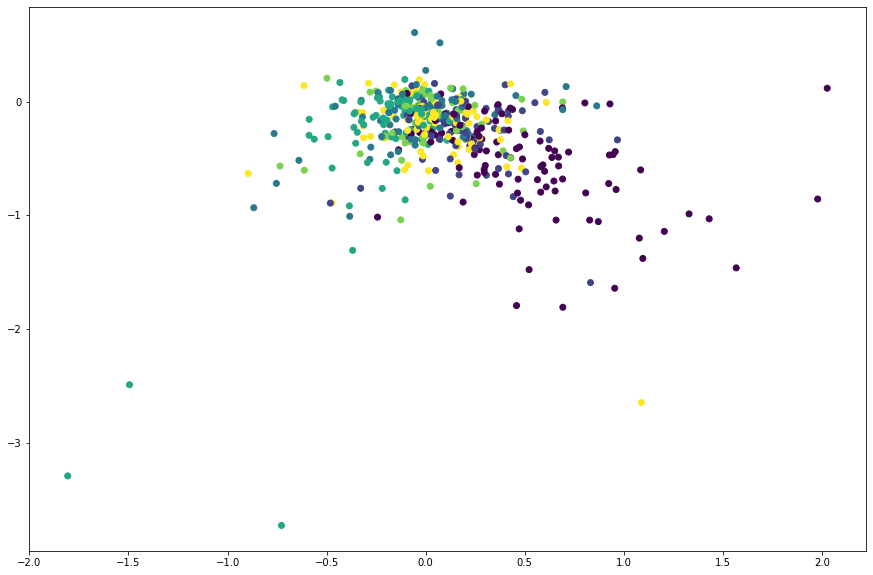

In [20]:
plt.figure(figsize=(15,10))
plt.scatter(x_train[:500,0], x_train[:500,1], c=[ord(a) for a in y_train[:500]])

# 3. Kmeans Clustering

Since we have a rough idea of how many clusters we would expect (because we already simplified the data) we decided first to try Kmeans clustering with the same number of clusters as we created our own categories.

In [21]:
#from sklearn.preprocessing import StandardScaler
#
#scaler = StandardScaler()
#scaled_data = scaler.fit_transform(x_train)

kmeans = KMeans(n_clusters=len(set(simp_map.values())))
predictions = kmeans.fit_predict(x_train)

## 3.1. Initial Analysis

In order to see how good the model works out of the box we want to know how accurate it managed to create these clusters according to our ground truth.

In [22]:
def calculateStatistics(ground_labels, predicted):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
   
    #check all pairs 
    for i in range(len(ground_labels)):
        for j in range(i+1, len(ground_labels)):
            # if they belong to the same cluster in round truth
            if ground_labels[i] == ground_labels[j]:
                # did they also match the same cluster from kmeans?
                if predicted[i] == predicted[j]:
                    TP = TP + 1
                else:
                    FN = FN + 1
            else:
                if predicted[i] == predicted[j]:
                    FP = FP + 1
                else:
                    TN = TN + 1
    return TP, FP, TN, FN

def printStatistics(TP, FP, TN, FN):
    print("TP : " + str(TP))
    print("TN : " + str(TN))
    print("FP : " + str(FP))
    print("FN : " + str(FN))
    print("right: " + str(TP + TN))
    print("wrong: " + str(FN + FP))
    print("ratio: " + str((TP + TN)/(FN + FP + TP + TN)))
    print("precision over all clusters: " + str(TP/(TP + FP)))
    print("recall over all clusters: " + str(TP/(TP + FN)))

In [23]:
ground_labels = [ord(text[-1])-ord('A') for text in y_train]

In [24]:
TP, FP, TN, FN = calculateStatistics(ground_labels, kmeans.labels_)
printStatistics(TP, FP, TN, FN)

TP : 1441106
TN : 11150900
FP : 5383012
FN : 1866832
right: 12592006
wrong: 7249844
ratio: 0.6346185461537105
precision over all clusters: 0.21117835301206692
recall over all clusters: 0.4356508495624767


The right/wrong ratio would indicate that it seems to perform very well, however this is simply not true. It is dominated by the amount of TN of which there naturally are a lot. 

Changing nothing we get an accuracy of about 30%. Considering the fact a random classifier with 6 classes has 16,6% accuracy (the perfect one 100%) we are at least doing better than random. But we don't consider 30% as sufficient so we asked ourselves why this could be? The main reasons we decided to explore further were:

- our arbitrary number of categories was wrong, the machine could possibly be right
- a general lack of hyperparameter tuning

When we look at a sample we don't even see indications of clusters:

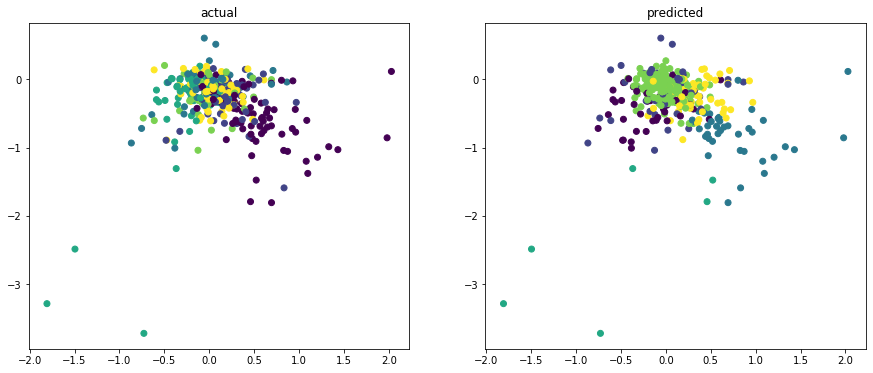

In [25]:
fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(1,2,2)
ax1.set_title('predicted')
ax1.scatter(x_train[:400,0], x_train[:400,1], c=predictions[:400])

ax2 = fig.add_subplot(1,2,1)
ax2.set_title('actual')
ax2.scatter(x_train[:400,0], x_train[:400,1], c=[ord(a) - ord('A') for a in y_train[:400]])

## 3.2. Determing K

First, we examine if we indeed made a mistake and the model was actually right. We did so by using silhouette analysis.

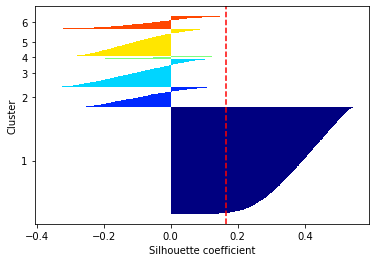

In [26]:
km = KMeans(n_clusters=6, init='k-means++', n_init=10, max_iter=300, tol=1e-04,random_state=0)
y_km = km.fit_predict(x_train)

import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(x_train, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
  c_silhouette_vals = silhouette_vals[y_km == c]
  c_silhouette_vals.sort()
  y_ax_upper += len(c_silhouette_vals)
  color = cm.jet(float(i) / n_clusters)
  plt.barh(range(y_ax_lower, y_ax_upper),
           c_silhouette_vals,
           height=1.0,
           edgecolor='none',
           color=color)
  yticks.append((y_ax_lower + y_ax_upper) / 2.)
  y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()

Silouhette analysis shows us that it actually does a fairly descent job. And elbow analysis seems to indicate that 6 categories is acutally a valid distinction.

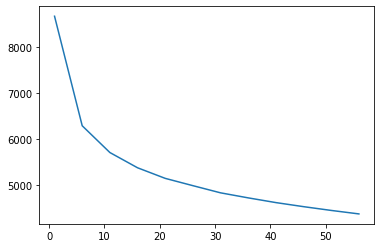

In [27]:
oplossingen = []
for i in range(1,60,5):
    kmeans = KMeans(n_clusters=i, init='k-means++')
    kmeans.fit(x_train)
    oplossingen.append(kmeans.inertia_)
plt.plot(range(1,60,5),oplossingen)

The elbow method did not give us a definitive answer as to why our precision is only 30%. This made us believe that de data is simply not suited for the Kmeans algorithm. Perhaps because it assumes spherical shapes for the clusters. That is why we decided to try DBScan clustering.

## 4. DBScan Clustering

Looking at the images where ground truths are shown we see that the clusters are not circular, however kmeans expects this. That is why we decided to try DBScan aswell. This technique works with densities instead of distances, which allows it to model non-circular clusters.

In [28]:
db = DBSCAN(eps=1.5, min_samples=4)
y_db = db.fit_predict(x_train)

## 4.1. Initial Analysis

In order to see how good the model works out of the box we want to know how accurate it managed to create these clusters according to our ground truth.

In [29]:
ground_labels = [ord(text[-1])-ord('A') for text in y_train]
TP, FP, TN, FN = calculateStatistics(ground_labels, db.labels_)
printStatistics(TP, FP, TN, FN)


TP : 3100253
TN : 1048684
FP : 15485228
FN : 207685
right: 4148937
wrong: 15692913
ratio: 0.20910031070691493
precision over all clusters: 0.16681047964268453
recall over all clusters: 0.9372161751520132


A basic implementation groups everything together in one cluster. Here we need some hyperparameter tuning.

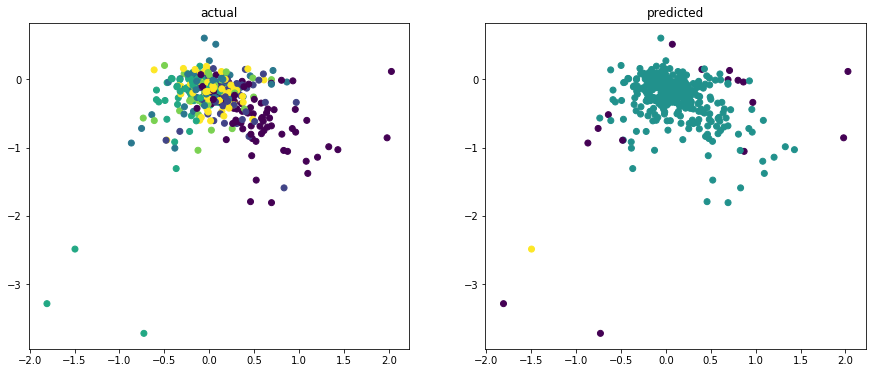

In [30]:
fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(1,2,2)
ax1.set_title('predicted')
ax1.scatter(x_train[:400,0], x_train[:400,1], c=y_db[:400])

ax2 = fig.add_subplot(1,2,1)
ax2.set_title('actual')
ax2.scatter(x_train[:400,0], x_train[:400,1], c=[ord(a) for a in y_train[:400]])

# 5. Doc2Vec + T-SNE + DBScan Hyperparameter tuning

Since this combination (Doc2Vec + T-SNE + DBScan) seemed most promising in theory we tried getting a better performance using pipelines since DBScan has no score for gridSearch.

https://scikit-learn.org/stable/modules/compose.html#pipeline



# Keras

In [67]:
# van eerder: alle niet belangrijke dingen wegfilteren
#data['Consumer complaint narrative'] = data['Consumer complaint narrative'].apply(preprocessing)
#data[['Consumer complaint narrative', 'TARGET']] bevat nog alle woorden etc voordat tfidf etc werd toegepast. -> gebruiken voor tokenizer
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.text import Tokenizer


tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Consumer complaint narrative'])
encoded_docs = tokenizer.texts_to_matrix(data['Consumer complaint narrative'], mode='count')
# sparse matrix, element staat 1 in indien woord in dat document voorkwam
print(encoded_docs.shape)
#[0] is aantal documetnen, [1] is aantal verschillende woorden -> aantal inputnodes voor nn nodig


(10000, 22191)


In [70]:
numTargets = [ord(x[-1])-ord('A') for x in data['TARGET']]
onehotTargets = keras.utils.to_categorical(numTargets, 6)
onehotTargets.shape

(10000, 6)

In [65]:
x_train, x_test, y_train, y_test = train_test_split(encoded_docs,onehotTargets,test_size = 0.3)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size= 0.1)


In [71]:

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(encoded_docs.shape[1],)))
model.add(Dense(200, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(onehotTargets.shape[1], activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               2840576   
_________________________________________________________________
dense_10 (Dense)             (None, 200)               25800     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               51456     
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 1542      
Total params: 2,919,374
Trainable params: 2,919,374
Non-trainable params: 0
_________________________________________________________________


Train on 6300 samples, validate on 700 samples
Epoch 1/10
6300/6300 [==============================] - 3s 468us/step - loss: 1.5871 - accuracy: 0.4973 - val_loss: 1.1427 - val_accuracy: 0.7086
Epoch 2/10
6300/6300 [==============================] - 2s 370us/step - loss: 0.8783 - accuracy: 0.7630 - val_loss: 0.8109 - val_accuracy: 0.7700
Epoch 3/10
6300/6300 [==============================] - 2s 369us/step - loss: 0.6672 - accuracy: 0.8110 - val_loss: 0.7315 - val_accuracy: 0.7957
Epoch 4/10
6300/6300 [==============================] - 2s 358us/step - loss: 0.5323 - accuracy: 0.8452 - val_loss: 0.7138 - val_accuracy: 0.8000
Epoch 5/10
6300/6300 [==============================] - 2s 391us/step - loss: 0.4335 - accuracy: 0.8721 - val_loss: 0.6954 - val_accuracy: 0.8014
Epoch 6/10
6300/6300 [==============================] - 2s 367us/step - loss: 0.3614 - accuracy: 0.8929 - val_loss: 0.7216 - val_accuracy: 0.8057
Epoch 7/10
6300/6300 [==============================] - 2s 362us/step - loss:

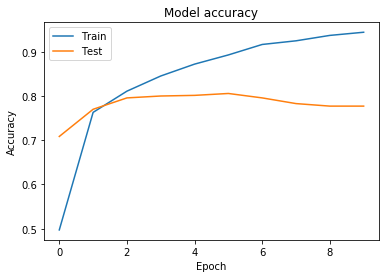

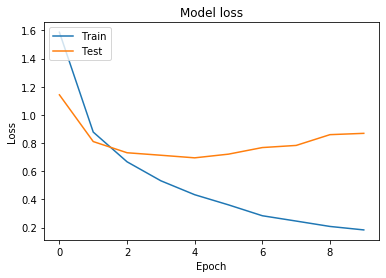

In [72]:
from keras.optimizers import SGD

batch_size = 128
epochs = 10

model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.9), metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, y_val))

score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()